## Setup

In [53]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


# Code to visualize the execution graph in the jupyter notebook
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
    

In [18]:
import tensorflow as tf

In [19]:
def plot_image(image,title=None):
    plt.figure()
    plt.imshow(image, cmap="gray", interpolation="nearest")
    if title is not None:
        plt.title(title)
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")
    
def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={X:np.reshape(stimuli,[1,784],order='F')})
    plotNNFilter(units)

# visualize convolution activations
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

# visualize convolution kernels
def plotConvLayerWeights(conv_layer_name, sess):
    kernel = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, conv_layer_name)[0]
    weights = sess.run(kernel)
    
    n_filters = int(kernel.shape[3])
    n_base_layers = int(kernel.shape[2])
    plt.figure(figsize=(20,20))
    for j in range(n_base_layers):
        for i in range(n_filters):
            plt.subplot(n_base_layers, n_filters, j * n_filters + i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(weights[:,:,j,i].reshape(kernel.shape[0],kernel.shape[1]), cmap='gray', interpolation='nearest')
            plt.title(str(i+1))

## Load MNIST

In [20]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


### Select 1459 and 023678 from MNIST

In [21]:
def prepare_data():
    global  dataset_1459_train, \
            dataset_023678_train, \
            X_1459_train, \
            y_1459_train, \
            X_1459_test, \
            y_1459_test, \
            X_023678_test, \
            y_023678_test, \
            X_023678_train, \
            y_023678_train
    mask_1459_train = np.logical_or.reduce([mnist.train.labels == v for v in [1,4,5,9]])
    mask_1459_test  = np.logical_or.reduce([mnist.test.labels  == v for v in [1,4,5,9]])
    X_1459_train = np.compress(np.array(mask_1459_train), mnist.train.images, axis=0)
    _, y_1459_train = np.unique(mnist.train.labels[mask_1459_train], return_inverse=True) # 1,4,5,9 to 0,1,2,3
    dataset_1459_train = tf.contrib.data.Dataset.from_tensor_slices((X_1459_train,y_1459_train))

    X_1459_test = np.compress(np.array(mask_1459_test), mnist.test.images, axis=0)
    _, y_1459_test = np.unique(mnist.test.labels[mask_1459_test], return_inverse=True)

    mask_023678_train = np.logical_or.reduce([mnist.train.labels == v for v in [0,2,3,6,7,8]])
    mask_023678_test  = np.logical_or.reduce([mnist.test.labels  == v for v in [0,2,3,6,7,8]])
    X_023678_train = np.compress(np.array(mask_023678_train), mnist.train.images, axis=0)
    _, y_023678_train = np.unique(mnist.train.labels[mask_023678_train], return_inverse=True) # 1,4,5,9 to 0,1,2,3
    dataset_023678_train = tf.contrib.data.Dataset.from_tensor_slices((X_023678_train,y_023678_train))

    X_023678_test = np.compress(np.array(mask_023678_test), mnist.test.images, axis=0)
    _, y_023678_test = np.unique(mnist.test.labels[mask_023678_test], return_inverse=True)

prepare_data()

# for example
plot_image(X_1459_test[2].reshape(28,28),title=y_1459_test[2])
plot_image(X_023678_test[2].reshape(28,28),title=y_023678_test[2])

# Convolutional Network

### Construct Graph

In [22]:
height = 28
width = 28
channels = 1
n_inputs = height * width
n_outputs = 4

reset_graph()
prepare_data()

# for drop out only
keep_prob = 0.97
# inputs layer
with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
#     DROP OUT CODE
#     drop_out = tf.placeholder(tf.float32)

with tf.name_scope("conv"):
    conv1 = tf.layers.conv2d(inputs=X_reshaped, name="conv1", kernel_size=[3, 3], filters=4, strides=1, padding="same", activation=tf.nn.relu)
    conv2 = tf.layers.conv2d(inputs=conv1, name="conv2",kernel_size=[3, 3], filters=8, strides=2, padding="same", activation=tf.nn.relu)

#     DROP OUT CODE
#     conv1 = tf.layers.conv2d(inputs=X_reshaped, name="conv1", kernel_size=[3, 3], filters=4, strides=1, padding="same", activation=tf.nn.relu)     drop1 = tf.nn.dropout(conv1,drop_out)
#     drop_layer_1 =  tf.nn.dropout(conv1, drop_out)  # DROP-OUT here
#     conv2 = tf.layers.conv2d(inputs=drop_layer_1, name="conv2",kernel_size=[3, 3], filters=8, strides=2, padding="same", activation=tf.nn.relu)
#     drop_layer_2 =  tf.nn.dropout(conv2, drop_out)  # DROP-OUT here
    
with tf.name_scope("pool3"):
    pool3 = tf.layers.max_pooling2d(inputs=conv2, strides=2, pool_size=[2, 2], name="pool3")
    pool3_flat = tf.reshape(pool3, [-1, 8*7*7])

with tf.name_scope("fc1"):
     fc1 = tf.layers.dense(pool3_flat, 16, name="fc1", activation=tf.nn.relu)
#     DROP OUT CODE
#     fc1 = tf.layers.dense(pool3_flat, 16, name="fc1", activation=tf.nn.relu)
#     drop_layer_3 =  tf.nn.dropout(fc1, drop_out)  # DROP-OUT here

with tf.name_scope("fc2"):
     fc2 = tf.layers.dense(fc1, 10, name="fc2", activation=tf.nn.relu)
#     DROP OUT CODE
#     fc2 = tf.layers.dense(drop_layer_3, 16, name="fc1", activation=tf.nn.relu)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc2, 4, activation=tf.nn.relu)
    Y_proba = tf.nn.softmax(logits)

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(tf.cast(xentropy, tf.float32))
    optimizer = tf.train.AdamOptimizer(0.0008)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

### Train 1459

In [23]:
n_epochs = 10
batch_size = 10

print("Training...")
with tf.Session() as sess:
    init.run()
    batched_dataset = dataset_1459_train.batch(batch_size)

    iterator = batched_dataset.make_initializable_iterator()
    next_batch = iterator.get_next()
    loss_1459_pts = []
    for epoch in range(n_epochs):
        sess.run(iterator.initializer)
        while True:
            try:
                X_batch, y_batch = sess.run(next_batch)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
#                 sess.run(training_op, feed_dict={X: X_batch, y: y_batch, drop_out: keep_prob})
            except tf.errors.OutOfRangeError:
                # finished running through dataset
                break

        acc_train = accuracy.eval(feed_dict={X: X_1459_train, y: y_1459_train})
        acc_test = accuracy.eval(feed_dict={X: X_1459_test, y: y_1459_test})
        loss_1459=  loss.eval(feed_dict={X: X_1459_test, y: y_1459_test})
#         loss_1459=  loss.eval(feed_dict={X: X_1459_test, y: y_1459_test, drop_out: keep_prob})
        loss_1459_pts.append(loss_1459)
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test, "Loss:", loss_1459)
        
    print("Finished training")

    print("Saving...")
    save_path = saver.save(sess, "./my_model_1459.ckpt")
    plt.plot(range(len(loss_1459_pts)),loss_1459_pts)
    plt.title("Test Loss - MNIST1459")
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.savefig("Test Loss-MNIST1459.png")
    plt.close()
    # for example
    inferred = sess.run(Y_proba, feed_dict={X: [X_1459_test[0]]})
    plot_image(X_1459_test[0].reshape(28,28), "Predicted %d, truth %d"%(np.argmax(inferred), y_1459_test[0]))

Training...
0 Train accuracy: 0.985406 Test accuracy: 0.990791 Loss: 0.426089
1 Train accuracy: 0.985132 Test accuracy: 0.988303 Loss: 0.0331472
2 Train accuracy: 0.991335 Test accuracy: 0.994027 Loss: 0.0190999
3 Train accuracy: 0.99398 Test accuracy: 0.994525 Loss: 0.0151179
4 Train accuracy: 0.994527 Test accuracy: 0.99552 Loss: 0.0140126
5 Train accuracy: 0.993342 Test accuracy: 0.992285 Loss: 0.0189027
6 Train accuracy: 0.993615 Test accuracy: 0.992285 Loss: 0.0211644
7 Train accuracy: 0.99056 Test accuracy: 0.991289 Loss: 0.0280714
8 Train accuracy: 0.994254 Test accuracy: 0.993529 Loss: 0.0162481
9 Train accuracy: 0.987823 Test accuracy: 0.986312 Loss: 0.0407215
Finished training
Saving...


### Build the graph for 023678

In [44]:
reset_graph()
prepare_data()

# restore the graph of 1459
restore_saver = tf.train.import_meta_graph("./my_model_1459.ckpt.meta")

# reuse the inputs (X,y)
X = tf.get_default_graph().get_tensor_by_name("inputs/X:0")
y = tf.get_default_graph().get_tensor_by_name("inputs/y:0")
# reuse the FC1 layer
fc1 = tf.get_default_graph().get_tensor_by_name("fc1/fc1/Relu:0")
# reuse the FC2 layer
fc2_reuse = tf.get_default_graph().get_tensor_by_name("fc2/fc2/Relu:0")

# continue the 023678 graph from FC2...
with tf.name_scope("fc2_023678"):
    fc2 = tf.layers.dense(fc1, 16,activation=tf.nn.relu,name="fc2_023678")
    
with tf.name_scope("softmax_023678"):
    logits = tf.layers.dense(fc2, 10,activation=tf.nn.relu, name="output_023678")
    Y_proba = tf.nn.softmax(logits, name="Y_proba_023678")

with tf.name_scope("train_023678"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
#     loss = tf.reduce_mean(xentropy)
    loss = tf.reduce_mean(tf.cast(xentropy, tf.float32))

    optimizer = tf.train.AdamOptimizer(0.0002,name="adam_023678")

## try to freeze everything but fc2, softmax
    optimizer = tf.train.AdamOptimizer(0.002,name="adam_023678")
#     train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="fc2_023678|softmax_023678")
#     training_op = optimizer.minimize(loss, var_list=train_vars)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval_023678"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_023678"):
    init = tf.global_variables_initializer()
    new_saver = tf.train.Saver()

## Train transferred 023678

In [45]:
n_epochs = 10
batch_size = 10

print("Training 023678...")
with tf.Session() as sess:
    init.run()
    batched_dataset = dataset_023678_train.batch(batch_size)

    iterator = batched_dataset.make_initializable_iterator()
    next_batch = iterator.get_next()
    
    saver.restore(sess, "./my_model_1459.ckpt")
    loss_023678_pts=[]
    for epoch in range(n_epochs):
        sess.run(iterator.initializer)
        while True:
            try:
                X_batch, y_batch = sess.run(next_batch)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
                
            except tf.errors.OutOfRangeError:
                # finished running through dataset
                break

        acc_train = accuracy.eval(feed_dict={X: X_023678_train, y: y_023678_train})
        acc_test = accuracy.eval(feed_dict={X: X_023678_test, y: y_023678_test})
        loss_023678 = loss.eval(feed_dict={X: X_023678_test, y: y_023678_test})
#         loss_023678 = loss.eval(feed_dict={X: X_023678_test, y: y_023678_test, drop_out:keep_prob})         
        loss_023678_pts.append(loss_023678)
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test, "Loss:", loss_023678)
    
    plt.plot(range(len(loss_023678_pts)),loss_023678_pts)
    plt.title("Test Loss - MNIST023678 with freeze")
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.savefig("Test Loss-MNIST023678 with freeze.png")

    print("Finished training")

    # for example
    inferred = sess.run(Y_proba, feed_dict={X: [X_023678_test[0]]})
    
    plot_image(X_023678_test[0].reshape(28,28), "Predicted %d, truth %d"%(np.argmax(inferred), y_023678_test[0]))

Training 023678...
INFO:tensorflow:Restoring parameters from ./my_model_1459.ckpt
0 Train accuracy: 0.980619 Test accuracy: 0.978435 Loss: 0.0718661
1 Train accuracy: 0.986152 Test accuracy: 0.981611 Loss: 0.0666084
2 Train accuracy: 0.988964 Test accuracy: 0.981946 Loss: 0.0608303
3 Train accuracy: 0.990324 Test accuracy: 0.982782 Loss: 0.0675475
4 Train accuracy: 0.99226 Test accuracy: 0.985289 Loss: 0.0590337
5 Train accuracy: 0.994497 Test accuracy: 0.986292 Loss: 0.0516415
6 Train accuracy: 0.992622 Test accuracy: 0.984119 Loss: 0.0597621
7 Train accuracy: 0.993529 Test accuracy: 0.985791 Loss: 0.0631139
8 Train accuracy: 0.995192 Test accuracy: 0.986292 Loss: 0.0608733
9 Train accuracy: 0.992592 Test accuracy: 0.984119 Loss: 0.0789775
Finished training


## Visualize the Feature Maps
The following code is useful to look into the activations of convolutional and pooling layers

INFO:tensorflow:Restoring parameters from ./my_model_1459.ckpt


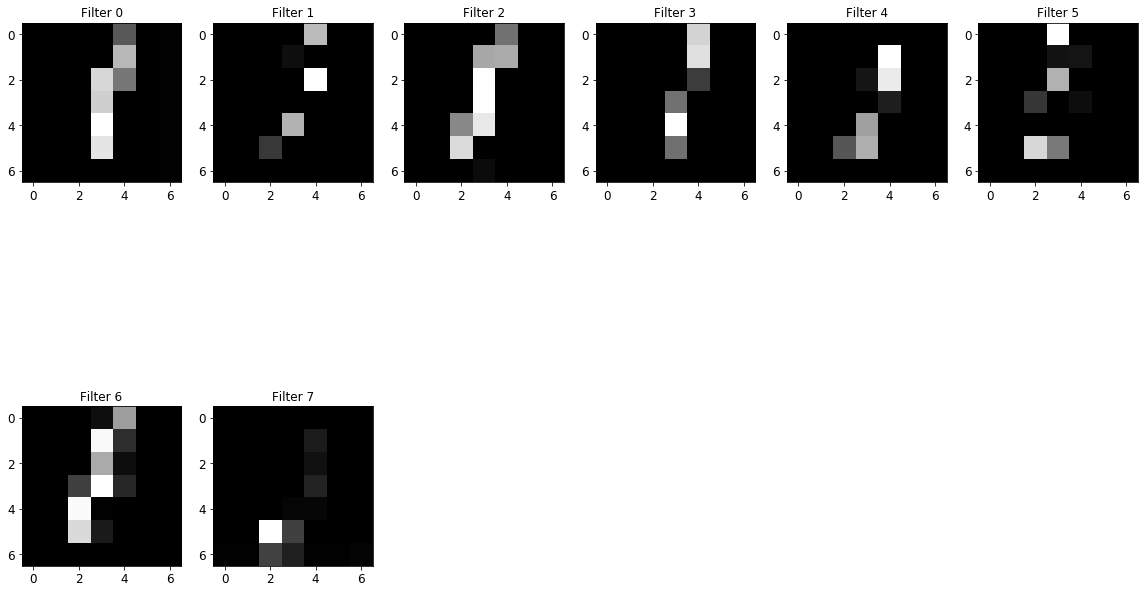

In [60]:
import math
with tf.Session() as sess:
    saver.restore(sess, "./my_model_1459.ckpt")
#     getActivations(tf.get_default_graph().get_tensor_by_name("conv/conv1/Relu:0"), X_1459_test[0])
#     getActivations(tf.get_default_graph().get_tensor_by_name("conv/conv2/Relu:0"), X_1459_test[0])
    getActivations(tf.get_default_graph().get_tensor_by_name("pool3/pool3/MaxPool:0"), X_1459_test[0])

### Visualize the convolution kernels

INFO:tensorflow:Restoring parameters from ./my_model_1459.ckpt


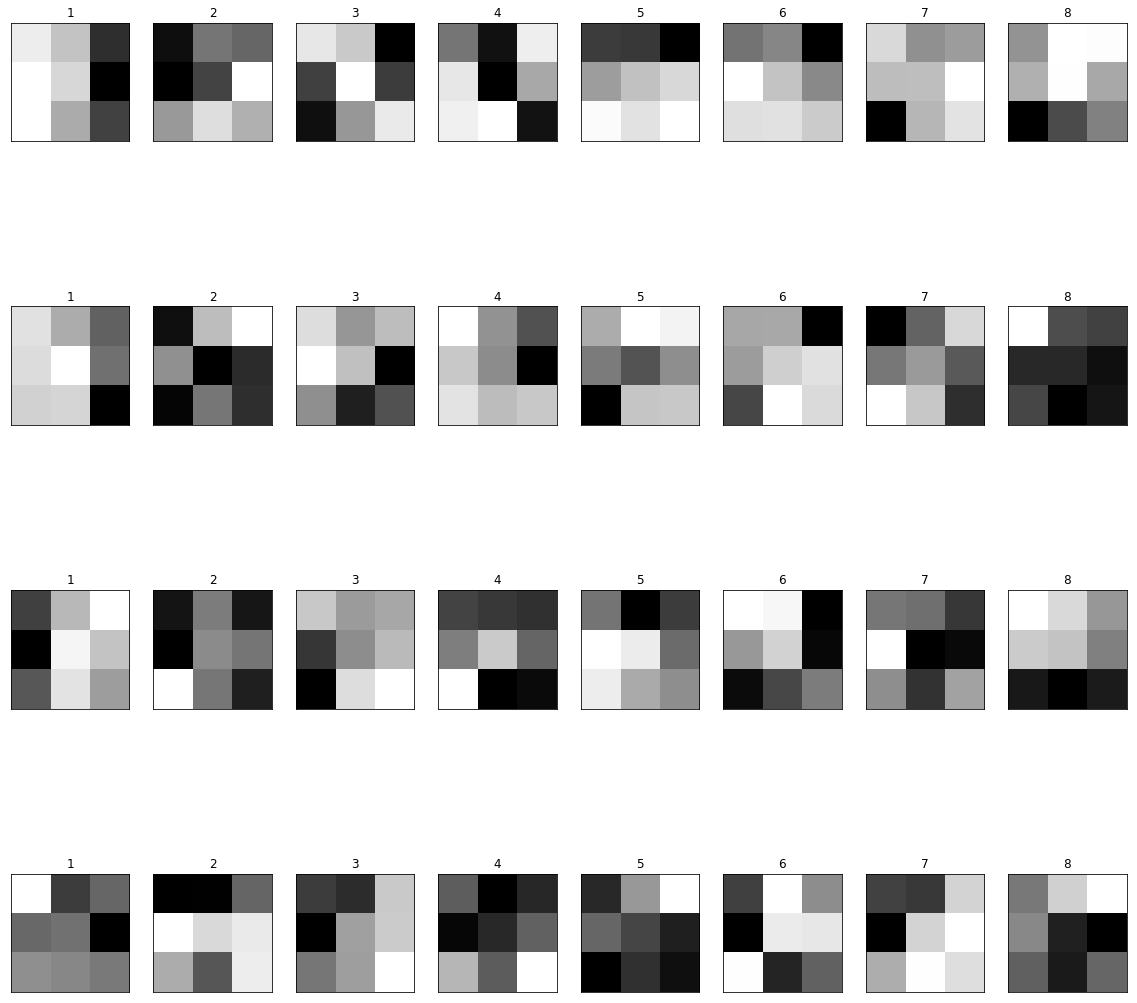

In [61]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_1459.ckpt")
#     plotConvLayerWeights("conv1",sess)
    plotConvLayerWeights("conv2",sess)

## Show the Execution Graph

In [62]:
reset_graph()

# restore the graph of 1459
restore_saver = tf.train.import_meta_graph("./my_model_1459.ckpt.meta")

show_graph(tf.get_default_graph())